In [1]:
# Fit notebook to browser window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import ROOT
import math 
import time
import os
import numpy as np
from array import array
import uproot
import pandas as pd

Welcome to JupyROOT 6.22/02


In [3]:
# Get input TTree
dir_in = '/grid_mnt/vol_home/llr/cms/portales/HIGtrigger/higgs-trigger-nanoaod/CMSSW_10_6_18/src/higgs-trigger-nanoaod/VBFparking_scripts/'

DFs = {}

file_in = dir_in + 'Run23Call_VBFall.root'
the_tree = uproot.open(file_in)['VBFNanoAOD/VBFtree']
df = ROOT.RDataFrame('VBFNanoAOD/VBFtree',file_in)

DFs['23C'] = df

file_in1 = dir_in + 'Run23Dall_VBFall.root'
the_tree1 = uproot.open(file_in1)['VBFNanoAOD/VBFtree']
df1 = ROOT.RDataFrame('VBFNanoAOD/VBFtree',file_in1)


DFs['23D'] = df1


file_in2 = dir_in + 'Run23all_VBFall.fixL1.root'
the_tree2 = uproot.open(file_in2)['VBFNanoAOD/VBFtree']
df2 = ROOT.RDataFrame('VBFNanoAOD/VBFtree',file_in2)


DFs['23all'] = df2



In [4]:
# highest mjj among all jet pairs (with pT>60 GeV, id tight) + additional variables for VBF jets
ROOT.gInterpreter.Declare('''
float get_VBF_var(TString var,
                  ROOT::VecOps::RVec<Float_t> pt,
                  ROOT::VecOps::RVec<Float_t> eta,
                  ROOT::VecOps::RVec<Float_t> phi,
                  ROOT::VecOps::RVec<Float_t> id,
                  ROOT::VecOps::RVec<Float_t> chf,
                  Float_t pt1cut,
                  Float_t pt2cut,
                  Float_t idcut,
                  Bool_t CHFcut) {
    
    Double_t mjj      = -1;
    Double_t detajj   = -1;
    Double_t etabest  = -999;
    Double_t etabest2 = -999;
    Double_t ptbest  = -999;
    Double_t ptbest2 = -999;
    Double_t chfbest  = -1;
    Double_t chfbest2 = -1;
    
    const auto size = pt.size();
    for (size_t idx1=0; idx1<size; ++idx1){
        for (size_t idx2=0; idx2<idx1; ++idx2){
        
            // VBF jets have to pass the ptcut2
            if (pt[idx1]<pt2cut || pt[idx2]<pt2cut)
                continue;
                           
            // in any case, we want tightly ID'd jets (just a safety, the condition should never be true)
            if (id[idx1]<idcut || id[idx2]<idcut)
                continue;

            // if CHFcut requirement is requested, check that both jets verify it
            if (CHFcut && ((abs(eta[idx1])<2.5 && chf[idx1]<0.3) ||
                           (abs(eta[idx2])<2.5 && chf[idx2]<0.3)   ))
                continue;

            // if minimal selection applies, get the jets 4-vec
            ROOT::Math::PtEtaPhiMVector p1(pt[idx1], eta[idx1], phi[idx1], 0.);
            ROOT::Math::PtEtaPhiMVector p2(pt[idx2], eta[idx2], phi[idx2], 0.);
            
            // check if the pair has best mjj, if so store VBF jets quantities
            if ((p1+p2).mass() > mjj) {
                mjj      = (p1+p2).mass();
                detajj   = abs(eta[idx1]-eta[idx2]);
                etabest  = (p1.pt()>p2.pt()) ? p1.eta():p2.eta();
                etabest2 = (p1.pt()>p2.pt()) ? p2.eta():p1.eta();
                ptbest   = (p1.pt()>p2.pt()) ? p1.pt():p2.pt();
                ptbest2  = (p1.pt()>p2.pt()) ? p2.pt():p1.pt();
                chfbest  = (p1.pt()>p2.pt()) ? chf[idx1]:chf[idx2];
                chfbest2 = (p1.pt()>p2.pt()) ? chf[idx2]:chf[idx1];
            }
        }
    }
    if (var=="mjj") 
        return mjj;
    if (var=="detajj")
        return detajj;
    if (var=="eta")
        return etabest;
    if (var=="eta2")
        return etabest2;
    if (var=="pt")
        return ptbest;
    if (var=="pt2")
        return ptbest2;
    if (var=="chf")
        return chfbest;
    if (var=="chf2")
        return chfbest2;
        
    return -999.;
}
'''
)

True

In [5]:
# highest mjj among all jet pairs (with pT>60 GeV, id tight) + additional variables for VBF jets
ROOT.gInterpreter.Declare('''
bool pass_pt_cut(ROOT::VecOps::RVec<Float_t> pt,
                  Float_t pt1cut,
                  Float_t pt2cut,
                  Bool_t nopt1cut,
                  Bool_t nopt2cut) {
        
    Double_t mjj      = -1;
    int idx_vbf1 = -1;
    int idx_vbf2 = -1;
    
    if (pt[0]<pt1cut && !nopt1cut) // 1 jet with pT > ptcut1 (HLT logic)
        return false;
      
    if (pt[1]<pt2cut && !nopt2cut) // 2 jets with pT > ptcut2 (HLT logic)
        return false;
    
    return true;
}
'''
)

True

In [7]:
# checking cuts to measure eff vs mjj
ROOT.gInterpreter.Declare('''
bool pass_VBF_cuts(TString plotvar,
                   ROOT::VecOps::RVec<Float_t> pt,
                   ROOT::VecOps::RVec<Float_t> eta,
                   ROOT::VecOps::RVec<Float_t> phi,
                   ROOT::VecOps::RVec<Float_t> id,
                   ROOT::VecOps::RVec<Float_t> chf,
                   Float_t pt1cut,
                   Float_t pt2cut,
                   Float_t mjjcut,
                   Float_t detajjcut,
                   Bool_t CHFcut,
                   Bool_t nopt1cut,
                   Bool_t nopt2cut) {
                   
    Bool_t pass = true;
    
    // check pt cuts
    pass = pass && (pass_pt_cut(pt,pt1cut,pt2cut,nopt1cut,nopt2cut) 
                    || plotvar=="pt2" || plotvar=="pt1");

    // check detajj cut
    pass = pass && (detajjcut < get_VBF_var("detajj",pt,eta,phi,id,chf,pt1cut,pt2cut,6,CHFcut) 
                    || plotvar=="detajj");

    // check mjj cut
    pass = pass && (mjjcut < get_VBF_var("mjj",pt,eta,phi,id,chf,pt1cut,pt2cut,6,CHFcut)
                    || plotvar=="mjj");


    return pass;
}
''')

True

In [8]:
def fill_eff(h_num, h_den, year,var,version):
    eff = ROOT.TGraphAsymmErrors(h_num[year][var][version].GetValue(),
                                 h_den[year][var].GetValue(),
                                 'eff_{}'.format(var))
    return eff


def redrawBorder():
    ROOT.gPad.Update()
    ROOT.gPad.RedrawAxis()
    l = ROOT.TLine()
    l.SetLineWidth(2)
    l.DrawLine(ROOT.gPad.GetUxmin(), ROOT.gPad.GetUymax(), ROOT.gPad.GetUxmax(), ROOT.gPad.GetUymax())
    l.DrawLine(ROOT.gPad.GetUxmax(), ROOT.gPad.GetUymin(), ROOT.gPad.GetUxmax(), ROOT.gPad.GetUymax())
    l.DrawLine(ROOT.gPad.GetUxmin(), ROOT.gPad.GetUymin(), ROOT.gPad.GetUxmin(), ROOT.gPad.GetUymax())
    l.DrawLine(ROOT.gPad.GetUxmin(), ROOT.gPad.GetUymin(), ROOT.gPad.GetUxmax(), ROOT.gPad.GetUymin())

def print_unique_runs(df):
    df_runs = df.AsNumpy(["run"])
    np.unique(df_runs['run'])
    for run in np.unique(df_runs['run']):
        print(run)

In [9]:
#periods = ["23C","23D","23all"]
periods = ["23all"]

pt1cut = 125.
pt2cut = 50.
mjjcut = 1100.
detajjcut = 4.0
idcut = 6
chfcut = "false"

df_mjj_all = {}

# apply basic filter & evaluate variables
for year in periods:
    
    # always apply pT requirement
    cut_df = DFs[year]#.Filter('jets_pt[0]>{} && jets_pt[1]>{}'.format(pt1cut,pt2cut))
    
    
    df_mjj_all[year] = cut_df\
                    .Define('mjj2',    'get_VBF_var( "mjj", jets_pt,jets_eta,jets_phi,jets_id,jets_CHF,{},{},{},{})'.format(pt1cut,pt2cut,idcut,chfcut))\
                    .Define('chfbest', 'get_VBF_var( "chf", jets_pt,jets_eta,jets_phi,jets_id,jets_CHF,{},{},{},{})'.format(pt1cut,pt2cut,idcut,chfcut))\
                    .Define('chfbest2','get_VBF_var( "chf2",jets_pt,jets_eta,jets_phi,jets_id,jets_CHF,{},{},{},{})'.format(pt1cut,pt2cut,idcut,chfcut))\
                    .Define('etabest', 'get_VBF_var( "eta", jets_pt,jets_eta,jets_phi,jets_id,jets_CHF,{},{},{},{})'.format(pt1cut,pt2cut,idcut,chfcut))\
                    .Define('etabest2','get_VBF_var( "eta2",jets_pt,jets_eta,jets_phi,jets_id,jets_CHF,{},{},{},{})'.format(pt1cut,pt2cut,idcut,chfcut))\
                    .Define('ptbest',  'get_VBF_var( "pt",  jets_pt,jets_eta,jets_phi,jets_id,jets_CHF,{},{},{},{})'.format(pt1cut,pt2cut,idcut,chfcut))\
                    .Define('ptbest2', 'get_VBF_var( "pt2", jets_pt,jets_eta,jets_phi,jets_id,jets_CHF,{},{},{},{})'.format(pt1cut,pt2cut,idcut,chfcut))\
                    .Define('Detajj',  'abs(etabest-etabest2)')

In [10]:
df_mjj_den = {}
df_mjj_numL1 = {}
df_mjj_num = {}
for year in periods:
    df_mjj_den[year] = df_mjj_all[year]

    # check triggers
    df_mjj_numL1[year]  = df_mjj_den[year].Filter('passL1VBFincl')
    df_mjj_num[year]    = df_mjj_den[year].Filter('passVBFincl_2j || passVBFincl_3j')

In [11]:
### VBF inclusive trigger plots

df_den = {}#df_mjj_all
df_num = {}#df_mjj_all

# define some filters and variables

# mjj -> "baseline" selection
pass_cuts_for_mjj = 'Detajj>4.0 ' + \
                    '&& pass_VBF_cuts("mjj",jets_pt,jets_eta,jets_phi,jets_id,jets_CHF,{},{},{},{},{},false,false)'.format(pt1cut,pt2cut,mjjcut,detajjcut,chfcut)

# mjj1 -> ommiting jet pt > ptcut2 (lower requirement at HLT)
pass_cuts_for_mjj1 = 'Detajj>4.0 ' + \
                    '&& pass_VBF_cuts("mjj",jets_pt,jets_eta,jets_phi,jets_id,jets_CHF,{},{},{},{},{},true,false)'.format(pt1cut,pt2cut,mjjcut,detajjcut,chfcut)


# mjj1 -> ommiting jet pt > ptcut2  (lower requirement at HLT)&& leading jet pt > ptcut 1 (higher requirement at HLT)
pass_cuts_for_mjj2 = 'Detajj>4.0 ' + \
                    '&& pass_VBF_cuts("mjj",jets_pt,jets_eta,jets_phi,jets_id,jets_CHF,{},{},{},{},{},true,true)'.format(pt1cut,pt2cut,mjjcut,detajjcut,chfcut)

# cuts for detajj using "baseline" pt selection
pass_cuts_for_detajj = 'mjj2>1100. && pass_VBF_cuts("detajj",jets_pt,jets_eta,jets_phi,jets_id,jets_CHF,{},{},{},{},{},false,false)'.format(pt1cut,pt2cut,mjjcut,detajjcut,chfcut)


for year in periods:
    print('Filling dfs for {}'.format(year))
    df_den[year] = {}
    df_den[year]['mjj'] = df_mjj_all[year].Filter(pass_cuts_for_mjj)
    df_den[year]['mjj1'] = df_mjj_all[year].Filter(pass_cuts_for_mjj1)
    df_den[year]['mjj2'] = df_mjj_all[year].Filter(pass_cuts_for_mjj2)
    df_den[year]['detajj'] = df_mjj_all[year].Filter(pass_cuts_for_detajj)
    
    df_num[year] = { 'mjj' : {}, 'detajj' : {}, 'mjj1' : {}, 'mjj2' : {} }
    df_num[year]['mjj']['new'] = df_den[year]['mjj'].Filter('passVBFincl_2j || passVBFincl_3j')
    df_num[year]['mjj']['L1']  = df_den[year]['mjj'].Filter('passL1VBFincl')
    
    df_num[year]['mjj1']['new'] = df_den[year]['mjj1'].Filter('passVBFincl_2j || passVBFincl_3j')
    df_num[year]['mjj1']['L1']  = df_den[year]['mjj1'].Filter('passL1VBFincl')
    
    df_num[year]['mjj2']['new'] = df_den[year]['mjj2'].Filter('passVBFincl_2j || passVBFincl_3j')
    df_num[year]['mjj2']['L1']  = df_den[year]['mjj2'].Filter('passL1VBFincl')
    
    df_num[year]['detajj']['new'] = df_den[year]['detajj'].Filter('passVBFincl_2j || passVBFincl_3j')
    df_num[year]['detajj']['L1']  = df_den[year]['detajj'].Filter('passL1VBFincl')
    


#hist from DF    
h_den = {}
h_num = {}
import time
for year in periods:
    print('Filling histograms for {}'.format(year))
    time_start = time.time()
    
    h_num[year] = {'mjj' : {}, 'detajj' : {}, 'mjj1' : {}, 'mjj2' : {} }
    h_den[year] = {}
    
    h_den[year]['mjj'] = df_den[year]['mjj'].Histo1D(    ('h_den','',   15,0,2500),'mjj2')
    print ("1 hist filled after {}".format(time.time() - time_start))
    
    h_num[year]['mjj'] = {
        'new': df_num[year]['mjj']['new'].Histo1D(    ('h_num_new','',   15,0,2500),'mjj2'),
        'L1':  df_num[year]['mjj']['L1'].Histo1D(     ('h_num_l1','',    15,0,2500),'mjj2'),
    }
    print ("2 hist filled after {}".format(time.time() - time_start))
    
    
    h_den[year]['mjj1'] = df_den[year]['mjj1'].Histo1D(    ('h_den','',   15,0,2500),'mjj2')   
    h_num[year]['mjj1'] = {
        'new': df_num[year]['mjj1']['new'].Histo1D(    ('h_num_new','',   15,0,2500),'mjj2'),
        'L1':  df_num[year]['mjj1']['L1'].Histo1D(     ('h_num_l1','',    15,0,2500),'mjj2'),
    }
    
    h_den[year]['mjj2'] = df_den[year]['mjj2'].Histo1D(    ('h_den','',   15,0,2500),'mjj2')   
    h_num[year]['mjj2'] = {
        'new': df_num[year]['mjj2']['new'].Histo1D(    ('h_num_new','',   15,0,2500),'mjj2'),
        'L1':  df_num[year]['mjj2']['L1'].Histo1D(     ('h_num_l1','',    15,0,2500),'mjj2'),
    }
    
    
    h_den[year]['detajj'] = df_den[year]['detajj'].Histo1D(    ('h_den','',   15,0,10),'detajj')
    print ("3 hist filled after {}".format(time.time() - time_start))
    
    h_num[year]['detajj'] = {
        'new': df_num[year]['detajj']['new'].Histo1D(    ('h_num_new','',   15,0,10),'detajj'),
        'L1':  df_num[year]['detajj']['L1'].Histo1D(     ('h_num_l1','',    15,0,10),'detajj'),
    }
    print ("4 hist filled after {}".format(time.time() - time_start))

    
print("all histo filled")

Filling dfs for 23all
Filling histograms for 23all
1 hist filled after 0.1204831600189209
2 hist filled after 0.12390708923339844
3 hist filled after 0.13528656959533691
4 hist filled after 0.13830113410949707
all histo filled


In [14]:
periods = ['23all']
Eff = {}
for year in periods:
    print('Evaluating efficiencies for {}'.format(year))
    Eff[year] = {'mjj' : {}, 'detajj' : {}, 'mjj1' : {}, 'mjj2' : {}}
    
    Eff[year]['mjj']['new']    = fill_eff(h_num, h_den, year, 'mjj', 'new')
    Eff[year]['mjj']['L1']     = fill_eff(h_num, h_den, year, 'mjj', 'L1' )
    
    Eff[year]['mjj1']['new']    = fill_eff(h_num, h_den, year, 'mjj1', 'new')
    Eff[year]['mjj1']['L1']     = fill_eff(h_num, h_den, year, 'mjj1', 'L1' )
    
    Eff[year]['mjj2']['new']    = fill_eff(h_num, h_den, year, 'mjj2', 'new')
    Eff[year]['mjj2']['L1']     = fill_eff(h_num, h_den, year, 'mjj2', 'L1' )
    
    Eff[year]['detajj']['new'] = fill_eff(h_num, h_den, year, 'detajj', 'new')
    Eff[year]['detajj']['L1']  = fill_eff(h_num, h_den, year, 'detajj', 'L1' )

Evaluating efficiencies for 23all


In [15]:
# Definingvariables, categories & cuts

jet_vars = ['pt1','pt2','mjj','detajj']

trigs = ['VBFincl','VBFjets','VBFmet' ,'VBFphot','VBFele' ,'VBFmu'  ,'VBFtau']

jet_cuts = {
        'VBFincl' : {"pt1": 125, "pt2":50, "mjj":1100, "detajj":4.0},
        'VBFjets' : {"pt1": 80,  "pt2":50, "mjj":800,  "detajj":2.8},
        'VBFmet'  : {"pt1": 85,  "pt2":50, "mjj":550,  "detajj":3.5},
        'VBFphot' : {"pt1": 55,  "pt2":55, "mjj":700,  "detajj":2.8},
        'VBFele'  : {"pt1": 55,  "pt2":55, "mjj":700,  "detajj":2.8},
        'VBFmu'   : {"pt1": 100, "pt2":50, "mjj":800,  "detajj":2.8},
        'VBFtau'  : {"pt1": 55,  "pt2":55, "mjj":700,  "detajj":2.8},
}

cut_str = {
    'mjj'    : 'detajj > {detajjcut} && pt2 > {pt2cut} && ((pt1>{pt1cut}) || (pt1>{pt2cut}&&j1_pt>{pt1cut}))',
    'pt1'    : 'detajj > {detajjcut} && pt2 > {pt2cut} && mjj > {mjjcut}',
    'pt2'    : 'detajj > {detajjcut} && mjj > {mjjcut} && ((pt1>{pt1cut}) || (pt1>{pt2cut}&&j1_pt>{pt1cut}))',
    'detajj' : 'mjj > {mjjcut} && pt2 > {pt2cut} && ((pt1>{pt1cut}) || (pt1>{pt2cut}&&j1_pt>{pt1cut}))',
    'centr'  : 'detajj > {detajjcut} && mjj > {mjjcut} && pt2 > {pt2cut} && ((pt1>{pt1cut}) || (pt1>{pt2cut}&&j1_pt>{pt1cut}))',
}

add_cut_str = {
        'VBFincl' : '1==1',
        'VBFjets' : 'passSelec_VBFjets==1',
        'VBFmet'  : 'MET_et>170',
        'VBFphot' : 'passSelec_VBFphot==1',
        'VBFele'  : '0==1',
        'VBFmu'   : '1==1',
        'VBFtau'  : '0==1',
}

add_cut_label = {
    'mjj'    : '#Delta#eta(j1,j2)>4.0',
    #'mjj'    : '#Delta#eta(j1,j2)>3.5',
    #'detajj' : 'm_{jj} > 800 GeV,MET(no-#mu) > 200 GeV',
    'detajj' : 'm_{jj} > 1100 GeV',
    'MET' : 'm_{jj} > 550 GeV, #Delta#eta(j1,j2)>3.5',
}

# Plotting labels
VARLABELS = {
    'mjj'    : 'm_{jj} [GeV]',
    'pt1'    : 'Leading jet p_{T} [GeV]',
    'pt2'    : 'Subleading jet p_{T} [GeV]',
    'detajj' : '#Delta#eta(j1,j2)',
    'MET'    : 'MET (no-#mu) [GeV]'
}


TRIGLABEL = {
    'VBFincl' : "HLT_VBF_DiPFJet105_40_Mjj1000_Detajj3p5*",
    'VBFjets' : "HLT_VBF_DiPFJet70_40_Mjj600_Detajj2p5_DiPFJet60*",
    'VBFmet'  : "HLT_VBF_DiPFJet75_40_Mjj500_Detajj2p5_PFMET85*",
    'VBFphot' : "HLT_VBF_DiPFJet45_Mjj500_Detajj2p5_Photon12*",
    'VBFele'  : "HLT_VBF_DiPFJet45_Mjj500_Detajj2p5_Ele12_eta2p1_WPTight_Gsf*",
    'VBFmu'   : "HLT_VBF_DiPFJet90_40_Mjj600_Detajj2p5_Mu3_TrkIsoVVL*",
    'VBFtau'  : "HLT_VBF_DiPFJet45_Mjj500_Detajj2p5_MediumDeepTauPFTauHPS45*",
}

import CMS_lumi, tdrstyle
import array


print(CMS_lumi.__file__)

tdrstyle.setTDRStyle()

#change the CMS_lumi variables (see CMS_lumi.py)
CMS_lumi.lumi_7TeV = "4.8 fb^{-1}"
CMS_lumi.lumi_8TeV = "18.3 fb^{-1}"
CMS_lumi.writeExtraText = True
CMS_lumi.extraText = "Preliminary"
CMS_lumi.lumi_sqrtS = "22.1 fb^{-1} - 2023 (13.6 TeV)" # used with iPeriod = 0, e.g. for simulation-only plots (default is an empty string)
iPeriod = 0

iPos = 0#11

H_ref = 600; 
W_ref = 600; 
W = W_ref
H = H_ref

# references for T, B, L, R
T = 0.08*H_ref
B = 0.14*H_ref 
L = 0.12*W_ref
R = 0.04*W_ref

theVar = 'mjj'
theTrig = 'VBFmet'

path = {}
legend = {}
canvas = {}
hpx = {}

text_coord = {
    'mjj' :    [1000,0.1,2400,0.7],
    'detajj' : [3.3,0.1,7.85,0.7],
    'MET' :    [170,0.04,390,0.64]
    
}

/grid_mnt/vol_home/llr/cms/portales/HIGtrigger/higgs-trigger-nanoaod/CMSSW_10_6_18/src/higgs-trigger-nanoaod/VBFparking_scripts/CMS_lumi.py


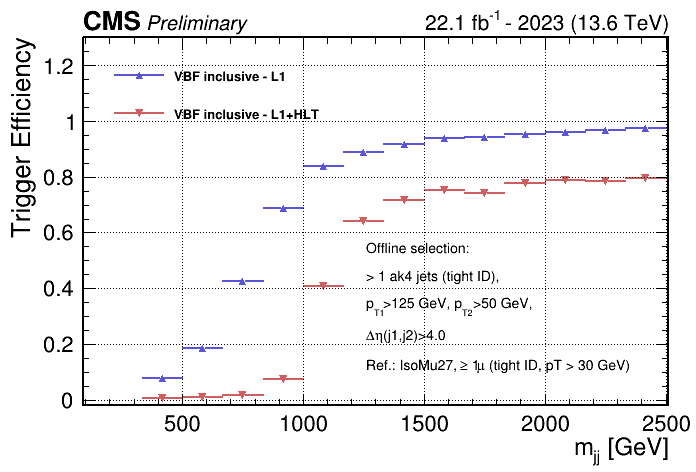

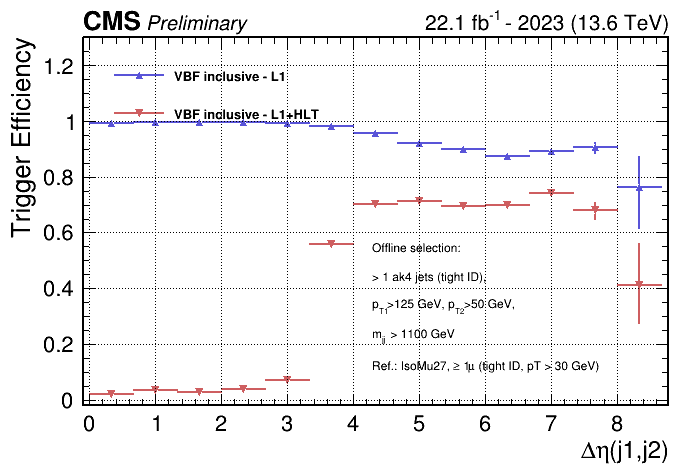

In [16]:
theYear = "23all"
#for theVar in ['mjj','detajj','MET']:
text_coord = {
    'mjj' :    [1200,0.07,2400,0.6],
    'detajj' : [4.1,0.07,7.95,0.6],
    'MET' :    [170,0.04,390,0.64]
    
}

for theVar in ['mjj','detajj']:
    
    Eff['23all'][theVar]['new'].SetLineColor(46)
    Eff['23all'][theVar]['new'].SetMarkerColor(46)
    Eff['23all'][theVar]['new'].SetLineWidth(2)
    Eff['23all'][theVar]['new'].SetMarkerStyle(23)   
    
    Eff['23all'][theVar]['L1'].SetLineColor(9)
    Eff['23all'][theVar]['L1'].SetMarkerColor(9)
    Eff['23all'][theVar]['L1'].SetLineWidth(2)
    Eff['23all'][theVar]['L1'].SetMarkerStyle(22)   
        
    path[theVar] = ROOT.TPaveText(text_coord[theVar][0],
                                  text_coord[theVar][1],
                                  text_coord[theVar][2],
                                  text_coord[theVar][3])
    
    path[theVar].SetTextAlign(12)
    path[theVar].SetFillStyle(0)
    path[theVar].SetBorderSize(0)
    
    path[theVar].AddText('Offline selection:')
    path[theVar].AddText('> 1 ak4 jets (tight ID), ')
    path[theVar].AddText('p_{T1}>125 GeV, p_{T2}>50 GeV, ') 
    path[theVar].AddText(add_cut_label[theVar])
    path[theVar].AddText('Ref.: IsoMu27, #geq 1#mu (tight ID, pT > 30 GeV) ')
        
    
#    legend[theVar] = ROOT.TLegend(0.65,0.75,0.90,0.90) # top right
    legend[theVar] = ROOT.TLegend(0.15,0.72,0.55,0.88) # top left
    legend[theVar].SetFillStyle(0)
    legend[theVar].SetBorderSize(0)
    legend[theVar].AddEntry(Eff['23all'][theVar]['L1'],   'VBF inclusive - L1',    'lp')
    legend[theVar].AddEntry(Eff['23all'][theVar]['new'],  'VBF inclusive - L1+HLT','lp')
    
    
    canvas[theVar]=ROOT.TCanvas(theVar,"Trigger Efficicency")
    canvas[theVar].SetFillColor(0)
    canvas[theVar].SetBorderMode(0)
    canvas[theVar].SetFrameFillStyle(0)
    canvas[theVar].SetFrameBorderMode(0)
    canvas[theVar].SetLeftMargin( L/W )
    canvas[theVar].SetRightMargin( R/W )
    canvas[theVar].SetTopMargin( T/H )
    canvas[theVar].SetBottomMargin( B/H )
    canvas[theVar].SetTickx()
    canvas[theVar].SetTicky()
    canvas[theVar].SetGrid()
    
    canvas[theVar].cd()
    
    #dummy hist for consistent display
    xlow=Eff[theYear][theVar]['new'].GetXaxis().GetBinLowEdge(0)
    xhigh=Eff[theYear][theVar]['new'].GetXaxis().GetBinUpEdge(92)
    hpx[theVar] = ROOT.TH2F("hpx","",10,xlow,xhigh,10,-0.02,1.3);
    hpx[theVar].SetStats(False)
    
    hpx[theVar].SetTitle(theVar)
    hpx[theVar].GetXaxis().SetTitle(VARLABELS[theVar])
    hpx[theVar].GetYaxis().SetTitle("Trigger Efficiency")
    hpx[theVar].GetXaxis().SetTitleSize(0.055)
    hpx[theVar].GetXaxis().SetTitleOffset(1.1)
    hpx[theVar].GetYaxis().SetTitleSize(0.06)
    hpx[theVar].GetYaxis().SetTitleOffset(0.9)
    hpx[theVar].Draw()

    Eff['23all'][theVar]['L1'].Draw("p same")
    Eff['23all'][theVar]['new'].Draw("p same")
    legend[theVar].Draw("same")
    path[theVar].Draw("same")
    canvas[theVar].Update()
    CMS_lumi.CMS_lumi(canvas[theVar], iPeriod, iPos)
    redrawBorder()
    canvas[theVar].Draw()
    canvas[theVar].SaveAs("./DPSplots/23C_vs_23D_VBFincl_{}.selCompCHFcut.pdf".format(theVar))
    canvas[theVar].SaveAs("./DPSplots/23C_vs_23D_VBFincl_{}.selCompCHFcut.png".format(theVar))

In [17]:

text_coord = {
    'mjj' :    [1200,0.07,2400,0.6],
    'detajj' : [4.1,0.07,7.95,0.6],
    'MET' :    [170,0.04,390,0.64]
    
}

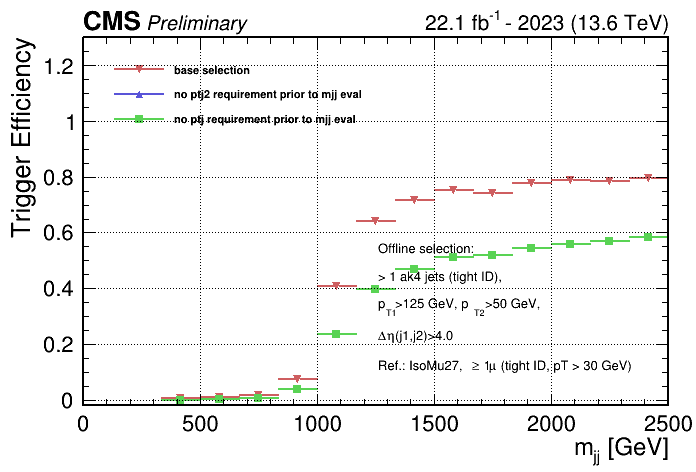

In [20]:
theYear = "23all"
#for mjj in ['mjj','detajj','MET']:
text_coord = {
    'mjj' :    [1200,0.07,2400,0.6],
    'detajj' : [4.1,0.07,7.95,0.6],
    'MET' :    [170,0.04,390,0.64]
    
}


Eff['23all']['mjj']['new'].SetLineColor(46)
Eff['23all']['mjj']['new'].SetMarkerColor(46)
Eff['23all']['mjj']['new'].SetLineWidth(2)
Eff['23all']['mjj']['new'].SetMarkerStyle(23)   

Eff['23all']['mjj1']['new'].SetLineColor(9)
Eff['23all']['mjj1']['new'].SetMarkerColor(9)
Eff['23all']['mjj1']['new'].SetLineWidth(2)
Eff['23all']['mjj1']['new'].SetMarkerStyle(22)   

Eff['23all']['mjj2']['new'].SetLineColor(8)
Eff['23all']['mjj2']['new'].SetMarkerColor(8)
Eff['23all']['mjj2']['new'].SetLineWidth(2)
Eff['23all']['mjj2']['new'].SetMarkerStyle(21)   
    
path['mjj'] = ROOT.TPaveText(text_coord['mjj'][0],
                             text_coord['mjj'][1],
                             text_coord['mjj'][2],
                             text_coord['mjj'][3])

path['mjj'].SetTextAlign(12)
path['mjj'].SetFillStyle(0)
path['mjj'].SetBorderSize(0)

path['mjj'].AddText('Offline selection:')
path['mjj'].AddText('> 1 ak4 jets (tight ID), ')
path['mjj'].AddText('p_{T1}>125 GeV, p_{T2}>50 GeV, ') 
path['mjj'].AddText(add_cut_label['mjj'])
path['mjj'].AddText('Ref.: IsoMu27, #geq 1#mu (tight ID, pT > 30 GeV) ')
    

#legend['mjj'] = ROOT.TLegend(0.65,0.75,0.90,0.90) # top right
legend['mjj'] = ROOT.TLegend(0.15,0.72,0.55,0.88) # top left
legend['mjj'].SetFillStyle(0)
legend['mjj'].SetBorderSize(0)
legend['mjj'].AddEntry(Eff['23all']['mjj']['new'],   'base selection',    'lp')
legend['mjj'].AddEntry(Eff['23all']['mjj1']['new'],  'no ptj2 requirement prior to mjj eval','lp')
legend['mjj'].AddEntry(Eff['23all']['mjj2']['new'],  'no ptj requirement prior to mjj eval','lp')


canvas['mjj']=ROOT.TCanvas('mjj',"Trigger Efficicency")
canvas['mjj'].SetFillColor(0)
canvas['mjj'].SetBorderMode(0)
canvas['mjj'].SetFrameFillStyle(0)
canvas['mjj'].SetFrameBorderMode(0)
canvas['mjj'].SetLeftMargin( L/W )
canvas['mjj'].SetRightMargin( R/W )
canvas['mjj'].SetTopMargin( T/H )
canvas['mjj'].SetBottomMargin( B/H )
canvas['mjj'].SetTickx()
canvas['mjj'].SetTicky()
canvas['mjj'].SetGrid()

canvas['mjj'].cd()

#dummy hist for consistent display
xlow=Eff[theYear]['mjj']['new'].GetXaxis().GetBinLowEdge(0)
xhigh=Eff[theYear]['mjj']['new'].GetXaxis().GetBinUpEdge(92)
#hpx['mjj'] = ROOT.TH2F("hpx","",10,xlow,xhigh,10,-0.02,1.3);
hpx['mjj'] = ROOT.TH2F("hpx","",10,0,2500,10,-0.02,1.3);
hpx['mjj'].SetStats(False)

hpx['mjj'].SetTitle('mjj')
hpx['mjj'].GetXaxis().SetTitle(VARLABELS['mjj'])
hpx['mjj'].GetYaxis().SetTitle("Trigger Efficiency")
hpx['mjj'].GetXaxis().SetTitleSize(0.055)
hpx['mjj'].GetXaxis().SetTitleOffset(1.1)
hpx['mjj'].GetYaxis().SetTitleSize(0.06)
hpx['mjj'].GetYaxis().SetTitleOffset(0.9)
hpx['mjj'].Draw()
Eff['23all']['mjj']['new'].Draw("p same")
Eff['23all']['mjj1']['new'].Draw("p same")
Eff['23all']['mjj2']['new'].Draw("p same")
legend['mjj'].Draw("same")
path['mjj'].Draw("same")
canvas['mjj'].Update()
CMS_lumi.CMS_lumi(canvas['mjj'], iPeriod, iPos)
redrawBorder()
canvas['mjj'].Draw()
canvas['mjj'].SaveAs("./DPSplots/23C_vs_23D_VBFincl_{}.selCompCHFcut.pdf".format('mjj'))
canvas['mjj'].SaveAs("./DPSplots/23C_vs_23D_VBFincl_{}.selCompCHFcut.png".format('mjj'))

In [19]:
xhigh

2508.666666666666

In [35]:
Eff['23all']['mjj2']['new'].Draw("p")